# Basic Text Classification with Naive Bayes
***
In the mini-project, you'll learn the basics of text analysis using a subset of movie reviews from the rotten tomatoes database. You'll also use a fundamental technique in Bayesian inference, called Naive Bayes. This mini-project is based on [Lab 10 of Harvard's CS109](https://github.com/cs109/2015lab10) class.  Please free to go to the original lab for additional exercises and solutions.

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from six.moves import range
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Setup Pandas
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

# Table of Contents

* [Rotten Tomatoes Dataset](#Rotten-Tomatoes-Dataset)
    * [Explore](#Explore)
* [The Vector Space Model and a Search Engine](#The-Vector-Space-Model-and-a-Search-Engine)
    * [In Code](#In-Code)
* [Naive Bayes](#Naive-Bayes)
    * [Multinomial Naive Bayes and Other Likelihood Functions](#Multinomial-Naive-Bayes-and-Other-Likelihood-Functions)
    * [Picking Hyperparameters for Naive Bayes and Text Maintenance](#Picking-Hyperparameters-for-Naive-Bayes-and-Text-Maintenance)
* [Interpretation](#Interpretation)


## Rotten Tomatoes Dataset

In [2]:
critics = pd.read_csv('./critics.csv')
#let's drop rows with missing quotes
critics = critics[~critics.quote.isnull()]
critics.head()

,critic,fresh,imdb,publication,quote,review_date,rtid,title
1,Derek Adams,fresh,114709,Time Out,"So ingenious in concept, design and execution ...",2009-10-04,9559,Toy story
2,Richard Corliss,fresh,114709,TIME Magazine,The year's most inventive comedy.,2008-08-31,9559,Toy story
3,David Ansen,fresh,114709,Newsweek,A winning animated feature that has something ...,2008-08-18,9559,Toy story
4,Leonard Klady,fresh,114709,Variety,The film sports a provocative and appealing st...,2008-06-09,9559,Toy story
5,Jonathan Rosenbaum,fresh,114709,Chicago Reader,"An entertaining computer-generated, hyperreali...",2008-03-10,9559,Toy story


### Explore

In [3]:
n_reviews = len(critics)
n_movies = critics.rtid.unique().size
n_critics = critics.critic.unique().size


print("Number of reviews: {:d}".format(n_reviews))
print("Number of critics: {:d}".format(n_critics))
print("Number of movies:  {:d}".format(n_movies))

Number of reviews: 15561
Number of critics: 623
Number of movies:  1921


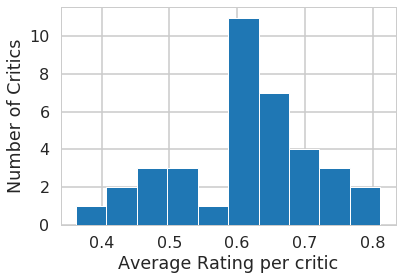

In [4]:
df = critics.copy()
df['fresh'] = df.fresh == 'fresh'
grp = df.groupby('critic')
counts = grp.critic.count()  # number of reviews by each critic
means = grp.fresh.mean()     # average freshness for each critic

means[counts > 100].hist(bins=10, edgecolor='w', lw=1)
plt.xlabel("Average Rating per critic")
plt.ylabel("Number of Critics")
plt.yticks([0, 2, 4, 6, 8, 10]);


### Exercise Set I  

**Exercise:** Look at the histogram above. Tell a story about the average ratings per critic. What shape does the distribution look like? What is interesting about the distribution? What might explain these interesting things?


The histogram represents the number of critics with over 100 reviews who had a particular average rating. For example, critic Bosley Crowther had over a 100 ratings. His average rating is 0.70, so he would be one of the four critics who fall in the average = 0.7 bin. Based on the histogram, majority of the critics have an average rating of 0.6 or higher. The distribution doesn't look normal. Maybe it looks more bimodal. The interesting thing about this distribution is that there seems to be a peak at 0.6 but very few critics have an average between 0.5 and 0.6. This can be because of small sample size. 

## The Vector Space Model and a Search Engine

All the diagrams here are snipped from [*Introduction to Information Retrieval* by Manning et. al.]( http://nlp.stanford.edu/IR-book/) which is a great resource on text processing. For additional information on text mining and natural language processing, see [*Foundations of Statistical Natural Language Processing* by Manning and Schutze](http://nlp.stanford.edu/fsnlp/).

Also check out Python packages [`nltk`](http://www.nltk.org/), [`spaCy`](https://spacy.io/), [`pattern`](http://www.clips.ua.ac.be/pattern), and their associated resources. Also see [`word2vec`](https://en.wikipedia.org/wiki/Word2vec).

Let us define the vector derived from document $d$ by $\bar V(d)$. What does this mean? Each document is treated as a vector containing information about the words contained in it. Each vector has the same length and each entry "slot" in the vector contains some kind of data about the words that appear in the document such as presence/absence (1/0), count (an integer) or some other statistic. Each vector has the same length because each document shared the same vocabulary across the full collection of documents -- this collection is called a *corpus*.

To define the vocabulary, we take a union of all words we have seen in all documents. We then just associate an array index with them. So "hello" may be at index 5 and "world" at index 99.

Suppose we have the following corpus:

`A Fox one day spied a beautiful bunch of ripe grapes hanging from a vine trained along the branches of a tree. The grapes seemed ready to burst with juice, and the Fox's mouth watered as he gazed longingly at them.`

Suppose we treat each sentence as a document $d$. The vocabulary (often called the *lexicon*) is the following:

$V = \left\{\right.$ `a, along, and, as, at, beautiful, branches, bunch, burst, day, fox, fox's, from, gazed, grapes, hanging, he, juice, longingly, mouth, of, one, ready, ripe, seemed, spied, the, them, to, trained, tree, vine, watered, with`$\left.\right\}$

Then the document

`A Fox one day spied a beautiful bunch of ripe grapes hanging from a vine trained along the branches of a tree`

may be represented as the following sparse vector of word counts:

$$\bar V(d) = \left( 4,1,0,0,0,1,1,1,0,1,1,0,1,0,1,1,0,0,0,0,2,1,0,1,0,0,1,0,0,1,1,1,0,0 \right)$$

or more succinctly as

`[(0, 4), (1, 1), (5, 1), (6, 1), (7, 1), (9, 1), (10, 1), (12, 1), (14, 1), (15, 1), (20, 2), (21, 1), (23, 1),`
`(26, 1), (29,1), (30, 1), (31, 1)]`

along with a dictionary

``
{
    0: a, 1: along, 5: beautiful, 6: branches, 7: bunch, 9: day, 10: fox, 12: from, 14: grapes, 15: hanging, 19: mouth, 20: of, 21: one, 23: ripe, 24: seemed, 25: spied, 26: the, 29:trained, 30: tree, 31: vine, 
}
``

Then, a set of documents becomes, in the usual `sklearn` style, a sparse matrix with rows being sparse arrays representing documents and columns representing the features/words in the vocabulary.

Notice that this representation loses the relative ordering of the terms in the document. That is "cat ate rat" and "rat ate cat" are the same. Thus, this representation is also known as the Bag-Of-Words representation.

Here is another example, from the book quoted above, although the matrix is transposed here so that documents are columns:

![novel terms](terms.png)

Such a matrix is also catted a Term-Document Matrix. Here, the terms being indexed could be stemmed before indexing; for instance, `jealous` and `jealousy` after stemming are the same feature. One could also make use of other "Natural Language Processing" transformations in constructing the vocabulary. We could use Lemmatization, which reduces words to lemmas: work, working, worked would all reduce to work. We could remove "stopwords" from our vocabulary, such as common words like "the". We could look for particular parts of speech, such as adjectives. This is often done in Sentiment Analysis. And so on. It all depends on our application.

From the book:
>The standard way of quantifying the similarity between two documents $d_1$ and $d_2$  is to compute the cosine similarity of their vector representations $\bar V(d_1)$ and $\bar V(d_2)$:

$$S_{12} = \frac{\bar V(d_1) \cdot \bar V(d_2)}{|\bar V(d_1)| \times |\bar V(d_2)|}$$

![Vector Space Model](vsm.png)


>There is a far more compelling reason to represent documents as vectors: we can also view a query as a vector. Consider the query q = jealous gossip. This query turns into the unit vector $\bar V(q)$ = (0, 0.707, 0.707) on the three coordinates below. 

![novel terms](terms2.png)

>The key idea now: to assign to each document d a score equal to the dot product:

$$\bar V(q) \cdot \bar V(d)$$

Then we can use this simple Vector Model as a Search engine.

### In Code

In [5]:
from sklearn.feature_extraction.text import CountVectorizer

text = ['Hop on pop', 'Hop off pop', 'Hop Hop hop']
print("Original text is\n{}".format('\n'.join(text)))

vectorizer = CountVectorizer(min_df=0)

# call `fit` to build the vocabulary
vectorizer.fit(text)

# call `transform` to convert text to a bag of words
x = vectorizer.transform(text)

# CountVectorizer uses a sparse array to save memory, but it's easier in this assignment to 
# convert back to a "normal" numpy array
x = x.toarray()

print("")
print("Transformed text vector is \n{}".format(x))

# `get_feature_names` tracks which word is associated with each column of the transformed x
print("")
print("Words for each feature:")
print(vectorizer.get_feature_names())

# Notice that the bag of words treatment doesn't preserve information about the *order* of words, 
# just their frequency

Original text is
Hop on pop
Hop off pop
Hop Hop hop

Transformed text vector is 
[[1 0 1 1]
 [1 1 0 1]
 [3 0 0 0]]

Words for each feature:
['hop', 'off', 'on', 'pop']


In [6]:
def make_xy(critics, vectorizer=None):
    #Your code here    
    if vectorizer is None:
        vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(critics.quote)
    X = X.tocsc()  # some versions of sklearn return COO format
    y = (critics.fresh == 'fresh').values.astype(np.int)
    return X, y
X, y = make_xy(critics)

## Naive Bayes

From Bayes' Theorem, we have that

$$P(c \vert f) = \frac{P(c \cap f)}{P(f)}$$

where $c$ represents a *class* or category, and $f$ represents a feature vector, such as $\bar V(d)$ as above. **We are computing the probability that a document (or whatever we are classifying) belongs to category *c* given the features in the document.** $P(f)$ is really just a normalization constant, so the literature usually writes Bayes' Theorem in context of Naive Bayes as

$$P(c \vert f) \propto P(f \vert c) P(c) $$

$P(c)$ is called the *prior* and is simply the probability of seeing class $c$. But what is $P(f \vert c)$? This is the probability that we see feature set $f$ given that this document is actually in class $c$. This is called the *likelihood* and comes from the data. One of the major assumptions of the Naive Bayes model is that the features are *conditionally independent* given the class. While the presence of a particular discriminative word may uniquely identify the document as being part of class $c$ and thus violate general feature independence, conditional independence means that the presence of that term is independent of all the other words that appear *within that class*. This is a very important distinction. Recall that if two events are independent, then:

$$P(A \cap B) = P(A) \cdot P(B)$$

Thus, conditional independence implies

$$P(f \vert c)  = \prod_i P(f_i | c) $$

where $f_i$ is an individual feature (a word in this example).

To make a classification, we then choose the class $c$ such that $P(c \vert f)$ is maximal.

There is a small caveat when computing these probabilities. For [floating point underflow](http://nlp.stanford.edu/IR-book/html/htmledition/naive-bayes-text-classification-1.html) we change the product into a sum by going into log space. This is called the LogSumExp trick. So:

$$\log P(f \vert c)  = \sum_i \log P(f_i \vert c) $$

There is another caveat. What if we see a term that didn't exist in the training data? This means that $P(f_i \vert c) = 0$ for that term, and thus $P(f \vert c)  = \prod_i P(f_i | c) = 0$, which doesn't help us at all. Instead of using zeros, we add a small negligible value called $\alpha$ to each count. This is called Laplace Smoothing.

$$P(f_i \vert c) = \frac{N_{ic}+\alpha}{N_c + \alpha N_i}$$

where $N_{ic}$ is the number of times feature $i$ was seen in class $c$, $N_c$ is the number of times class $c$ was seen and $N_i$ is the number of times feature $i$ was seen globally. $\alpha$ is sometimes called a regularization parameter.

### Multinomial Naive Bayes and Other Likelihood Functions

Since we are modeling word counts, we are using variation of Naive Bayes called Multinomial Naive Bayes. This is because the likelihood function actually takes the form of the multinomial distribution.

$$P(f \vert c) = \frac{\left( \sum_i f_i \right)!}{\prod_i f_i!} \prod_{f_i} P(f_i \vert c)^{f_i} \propto \prod_{i} P(f_i \vert c)$$

where the nasty term out front is absorbed as a normalization constant such that probabilities sum to 1.

There are many other variations of Naive Bayes, all which depend on what type of value $f_i$ takes. If $f_i$ is continuous, we may be able to use *Gaussian Naive Bayes*. First compute the mean and variance for each class $c$. Then the likelihood, $P(f \vert c)$ is given as follows

$$P(f_i = v \vert c) = \frac{1}{\sqrt{2\pi \sigma^2_c}} e^{- \frac{\left( v - \mu_c \right)^2}{2 \sigma^2_c}}$$


### Exercise Set II  

**Exercise:** Implement a simple Naive Bayes classifier:


* Split the data set into a training and test set
* Use `scikit-learn`'s `MultinomialNB()` classifier with default parameters.
* train the classifier over the training set and test on the test set
* print the accuracy scores for both the training and the test sets


What do you notice? Is this a good classifier? If not, why not?


In [7]:
from sklearn.naive_bayes import MultinomialNB
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size = 0.75, test_size = 0.25)
multi_nb_model = MultinomialNB()
multi_nb_model.fit(x_train, y_train)

training_accuracy = multi_nb_model.score(x_train, y_train)
print("Accuracy on training set: {}".format(training_accuracy))

test_accuracy = multi_nb_model.score(x_test, y_test)
print("Accuracy on test set: {}".format(test_accuracy))

Accuracy on training set: 0.9216795201371036
Accuracy on test set: 0.7725520431765613


The accuracy on the training set is pretty good (0.92). However, the accuracy on the test (0.78) is pretty different from the accuracy on the training set. This suggests that the model is overfit.

### Picking Hyperparameters for Naive Bayes and Text Maintenance

We need to know what value to use for $\alpha$, and we also need to know which words to include in the vocabulary. As mentioned earlier, some words are obvious stopwords. Other words appear so infrequently that they serve as noise, and other words in addition to stopwords appear so frequently that they may also serve as noise.

First, let's find an appropriate value for `min_df` for the `CountVectorizer`. `min_df` can be either an integer or a float/decimal. If it is an integer, `min_df` represents the minimum number of documents a word must appear in for it to be included in the vocabulary. If it is a float, it represents the minimum *percentage* of documents a word must appear in to be included in the vocabulary. From the documentation:

>min_df: When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold. This value is also called cut-off in the literature. If float, the parameter represents a proportion of documents, integer absolute counts. This parameter is ignored if vocabulary is not None.

### Exercise Set III  

**Exercise:** Construct the cumulative distribution of document frequencies (df). The $x$-axis is a document count $x_i$ and the $y$-axis is the percentage of words that appear less than $x_i$ times. For example, at $x=5$, plot a point representing the percentage or number of words that appear in 5 or fewer documents.

In [8]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n + 1) / n # increase by 1/n per point

    return x, y

In [9]:
X_array = X.toarray() # change csc matrix to array
X_yes_no = np.where(X_array > 0, 1, 0) # replace values > 0 with 1

In [10]:
doc_count_per_word = X_yes_no.sum(axis = 0) # sum columnwise (number of documents a word appears in)

In [11]:
# create x and y values for ecdf
x_ecdf, y_ecdf = ecdf(doc_count_per_word) # calculate the ecdf points

In [12]:
x_subset = x_ecdf[x_ecdf < 40] # subset of ecdf points for zooming in
y_subset = y_ecdf[x_ecdf < 40] # subset of ecdf points for zooming in

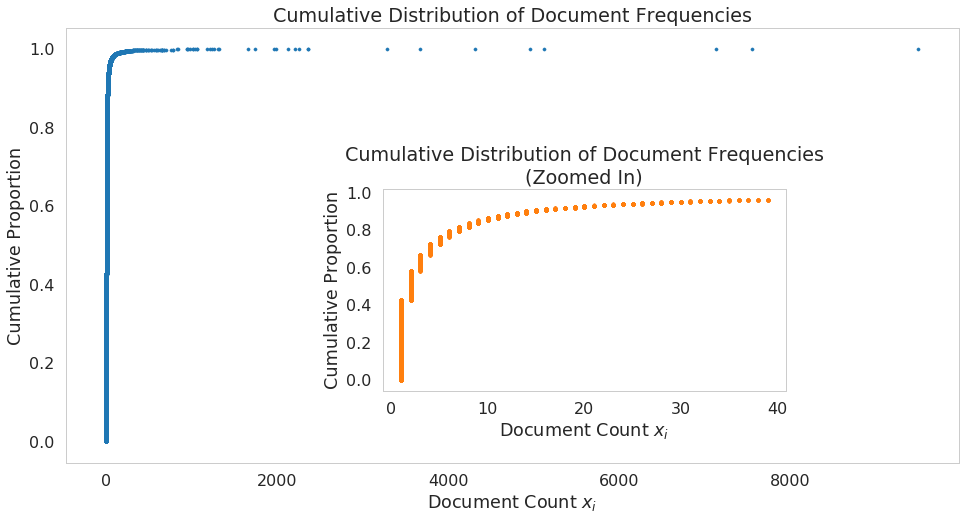

In [13]:
# Plot the entire series 
plt.figure(figsize = (16, 8))

# large plot
plt.scatter(x = x_ecdf, y = y_ecdf, s = 10)
plt.title('Cumulative Distribution of Document Frequencies')
plt.xlabel('Document Count ' + r'$x_i$')
plt.ylabel('Cumulative Proportion')
plt.grid(False)

# zoomed in plot
plt.axes([0.4, 0.25, 0.35, 0.35])
plt.scatter(x = x_subset, y = y_subset, s = 10, color = sns.color_palette().as_hex()[1])
plt.title('Cumulative Distribution of Document Frequencies\n(Zoomed In)')
plt.xlabel('Document Count ' + r'$x_i$')
plt.ylabel('Cumulative Proportion')
plt.grid(False)
plt.show()

**Exercise:** Look for the point at which the curve begins climbing steeply. This may be a good value for `min_df`. If we were interested in also picking `max_df`, we would likely pick the value where the curve starts to plateau. What value did you choose?

In [14]:
sum(doc_count_per_word == 1)

9586

In [15]:
sum(doc_count_per_word == 1) / len(doc_count_per_word)

0.42762189409822904

I will choose `min_df` $= 1$ because there are 9586 words (42.8 % of the words) that appear in only one document.

For `max_df`,  I would choose 10, because it seems like the curve starts to plateau from there.

The parameter $\alpha$ is chosen to be a small value that simply avoids having zeros in the probability computations. This value can sometimes be chosen arbitrarily with domain expertise, but we will use K-fold cross validation. In K-fold cross-validation, we divide the data into $K$ non-overlapping parts. We train on $K-1$ of the folds and test on the remaining fold. We then iterate, so that each fold serves as the test fold exactly once. The function `cv_score` performs the K-fold cross-validation algorithm for us, but we need to pass a function that measures the performance of the algorithm on each fold. 

In [16]:
from sklearn.model_selection import KFold
def cv_score(clf, X, y, scorefunc):
    result = 0.
    nfold = 5
    for train, test in KFold(nfold).split(X): # split data into train/test groups, 5 times
        clf.fit(X[train], y[train]) # fit the classifier, passed is as clf.
        result += scorefunc(clf, X[test], y[test]) # evaluate score function on held-out data
    return result / nfold # average

We use the log-likelihood as the score here in `scorefunc`. The higher the log-likelihood, the better. Indeed, what we do in `cv_score` above is to implement the cross-validation part of `GridSearchCV`.

The custom scoring function `scorefunc` allows us to use different metrics depending on the decision risk we care about (precision, accuracy, profit etc.) directly on the validation set. You will often find people using `roc_auc`, precision, recall, or `F1-score` as the scoring function.

In [17]:
def log_likelihood(clf, x, y):
    prob = clf.predict_log_proba(x)
    rotten = y == 0
    fresh = ~rotten
    return prob[rotten, 0].sum() + prob[fresh, 1].sum()

We'll cross-validate over the regularization parameter $\alpha$.

Let's set up the train and test masks first, and then we can run the cross-validation procedure.

In [18]:
_, itest = train_test_split(range(critics.shape[0]), train_size=0.7)
mask = np.zeros(critics.shape[0], dtype=np.bool)
mask[itest] = True # randomly set indices to True for test set

/root/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


### Exercise Set IV  

**Exercise:** What does using the function `log_likelihood` as the score mean? What are we trying to optimize for?

`log_likelihood` function is a function of the parameter $\alpha$. That is, given a value of $\alpha$, what is the probability of obtaining the data that we got? Here, our data is the feature set $f$ given that the the document is in class $c$. The likelihood function for our problem is the following:

$$P(f \vert c)  = \prod_i P(f_i | c) $$

where $f_i$ is an individual feature (a word in this example).

As mentioned above, to deal with the case where $P(f_i | c) = 0$, we use Laplace Smoothing. Hence we have 

$$P(f_i \vert c) = \frac{N_{ic}+\alpha}{N_c + \alpha N_i}$$

and 

$$P(f \vert c)  = \prod_i P(f_i \vert c) = \prod_i \frac{N_{ic}+\alpha}{N_c + \alpha N_i} $$

where $N_{ic}$ is the number of times feature $i$ was seen in class $c$, $N_c$ is the number of times class $c$ was seen and $N_i$ is the number of times feature $i$ was seen globally.

We take the log of this likelihood because log is a monotonic transformation and working with sums is easier than working with products. Hence, our log likelihood function now becomes:

$$\log P(f \vert c)  = \sum_i \log P(f_i \vert c) $$

We want to find $\alpha$ such that it maximizes the probability of getting the feature vector $f$ given $c$. Ultimately, we are trying to find the probability that a document (or whatever we are classifying) belongs to category *c* given the features in the document. The likelihood function is important because of the following relationship (as mentioned above):

$$P(c \vert f) \propto P(f \vert c) P(c) $$

We are finding $\alpha$ to maximize the likelihood function. By doing this, we are trying to optimize by finding the maximum probability $P(c \vert f)$.

**Exercise:** Without writing any code, what do you think would happen if you choose a value of $\alpha$ that is too high?

Large values of $\alpha$ would drown out the signal that we need. That is, given the following:

$$P(f_i \vert c) = \frac{N_{ic}+\alpha}{N_c + \alpha N_i}$$

$$\lim_{\alpha \rightarrow \infty} P(f_i \vert c) \rightarrow \frac{\alpha}{\alpha N_i} = \frac{1}{N_i}$$

This means that all the probabilities would represent the inverse of the number of times the feature $i$ (i.e. specific word) was seen globally. However, what we actually want is the probability of feature $i$ appearing in class $c$.

**Exercise:** Using the skeleton code below, find the best values of the parameter `alpha`, and use the value of `min_df` you chose in the previous exercise set. Use the `cv_score` function above with the `log_likelihood` function for scoring.

In [19]:
#the grid of parameters to search over
alphas = [.1, 1, 5, 10, 50]
min_df = 1
best_min_df = 1 # YOUR TURN: put your value of min_df here.

#Find the best value for alpha and min_df, and the best classifier
best_alpha = None
maxscore=-np.inf
for alpha in alphas:        
    vectorizer = CountVectorizer(min_df=best_min_df)       
    Xthis, ythis = make_xy(critics, vectorizer)
    Xtrainthis = Xthis[mask]
    ytrainthis = ythis[mask]
    
    # create a multinomial model with alpha value
    nb_model = MultinomialNB(alpha = alpha)
    
    # calculate the cross-validation score with log_likelihood as the metric
    log_lik = cv_score(nb_model, Xtrainthis, ytrainthis, log_likelihood)
    
    # find maximum log_lik value
    if log_lik > maxscore:
        maxscore = log_lik
        best_alpha = alpha

In [20]:
print("alpha: {}".format(best_alpha))

alpha: 1



### Exercise Set V: Working with the Best Parameters  

**Exercise:** Using the best value of  `alpha` you just found, calculate the accuracy on the training and test sets. Is this classifier better? Why (not)?



In [21]:
vectorizer = CountVectorizer(min_df=best_min_df)
X, y = make_xy(critics, vectorizer)
xtrain=X[mask]
ytrain=y[mask]
xtest=X[~mask]
ytest=y[~mask]

clf = MultinomialNB(alpha=best_alpha).fit(xtrain, ytrain)

#your turn. Print the accuracy on the test and training dataset
training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))

Accuracy on training data: 0.932962
Accuracy on test data:     0.731362


The model is not better than the previous model using default values. The model is not more accurate. It is also overfitting. The reason for this is because the best $\alpha$ value is the same as the default $\alpha$ value ($\alpha = 1$).

In [22]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(ytest, clf.predict(xtest)))

[[1975 2262]
 [ 664 5991]]


## Interpretation

### What are the strongly predictive features?

We use a neat trick to identify strongly predictive features (i.e. words). 

* first, create a data set such that each row has exactly one feature. This is represented by the identity matrix.
* use the trained classifier to make predictions on this matrix
* sort the rows by predicted probabilities, and pick the top and bottom $K$ rows

In [23]:
words = np.array(vectorizer.get_feature_names())

x = np.eye(xtest.shape[1]) # identity matrix with n = number of words (features)
probs = clf.predict_log_proba(x)[:, 0] # log of the probabilities; take first column because it represents P(fresh | word)
                                       # the other column represents P(rotten | word)
ind = np.argsort(probs) # returns the indices that would sort probs

good_words = words[ind[:10]]
bad_words = words[ind[-10:]]

good_prob = probs[ind[:10]]
bad_prob = probs[ind[-10:]]

print("Good words\t     P(fresh | word)")
for w, p in zip(good_words, good_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))
    
print("Bad words\t     P(fresh | word)")
for w, p in zip(bad_words, bad_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))

Good words	     P(fresh | word)
              superb 0.96
           excellent 0.95
             delight 0.95
            funniest 0.94
         imaginative 0.93
         achievement 0.93
           absorbing 0.93
             rousing 0.93
            touching 0.93
              ironic 0.92
Bad words	     P(fresh | word)
            remotely 0.14
            mediocre 0.14
              unless 0.13
          frequently 0.13
       disappointing 0.13
          schumacher 0.13
               bland 0.10
                lame 0.10
           pointless 0.09
       unfortunately 0.09



### Exercise Set VI  

**Exercise:** Why does this method work? What does the probability for each row in the identity matrix represent



This method works because the identity matrix represents data such that the document contains only one occurrence of a specific word. In other words, these are one-word documents. The probability of each row represents $P(c = fresh | f_i)$ where $f_i$ is an individual word. So, given that a document has only one word, $f_i$, what is the probability that the document is in class `fresh`? This is what we calculate. So, selecting the highest ten and lowest ten probabilities represent the top ten and bottom ten words that would help us to classify the document.

The above exercise is an example of *feature selection*. There are many other feature selection methods. A list of feature selection methods available in `sklearn` is [here](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection). The most common feature selection technique for text mining is the chi-squared $\left( \chi^2 \right)$ [method](http://nlp.stanford.edu/IR-book/html/htmledition/feature-selectionchi2-feature-selection-1.html).

### Prediction Errors

We can see mis-predictions as well.

In [24]:
x, y = make_xy(critics, vectorizer)

prob = clf.predict_proba(x)[:, 0]
predict = clf.predict(x)

bad_rotten = np.argsort(prob[y == 0])[:5]
bad_fresh = np.argsort(prob[y == 1])[-5:]

print("Mis-predicted Rotten quotes")
print('---------------------------')
for row in bad_rotten:
    print(critics[y == 0].quote.iloc[row])
    print("")

print("Mis-predicted Fresh quotes")
print('--------------------------')
for row in bad_fresh:
    print(critics[y == 1].quote.iloc[row])
    print("")

Mis-predicted Rotten quotes
---------------------------
While Leone's vision still has a magnificent sweep, the film finally subsides to an emotional core that is sombre, even elegiac, and which centres on a man who is bent and broken by time, and finally left with nothing but an impotent sadness.

An ambitious, serious but not particularly stimulating musical feature that unconvincingly attempts to graft warm and cuddly family-film motifs onto turbulent aspects of modern history and mythology.

Walken is one of the few undeniably charismatic male villains of recent years; he can generate a snakelike charm that makes his worst characters the most memorable, and here he operates on pure style.

Despite the fitful energy and the beauty of the settings, the ugliness of the mise en scene and the crudity of the editing tend to triumph.

If it's to be experienced at all, Return to Paradise is best seen as a lively piece of pulp, not a profound exploration of the vagaries of the human soul.




### Exercise Set VII: Predicting the Freshness for a New Review  

<div>
**Exercise:**
<ul>
* Using your best trained classifier, predict the freshness of the following sentence: *'This movie is not remarkable, touching, or superb in any way'*
* Is the result what you'd expect? Why (not)?
</ul>



In [25]:
# movie review
review = ['This movie is not remarkable, touching, or superb in any way']

# convert review to bag of words
bag_of_words_review = vectorizer.transform(review)

# predict the class
prediction = clf.predict(bag_of_words_review)

# print the result
if prediction == 1: print('Fresh')
else: print('Rotten')

Fresh


The result is not what I expected because the review is supposed to be classified as 'Rotten'. The reason for this is probably because of words like remarkable, touching, and superb. For example, superb is a word that has 95% of being classified as fresh according to the output of the predictive words above.

### Aside: TF-IDF Weighting for Term Importance

TF-IDF stands for 

`Term-Frequency X Inverse Document Frequency`.

In the standard `CountVectorizer` model above, we used just the term frequency in a document of words in our vocabulary. In TF-IDF, we weight this term frequency by the inverse of its popularity in all documents. For example, if the word "movie" showed up in all the documents, it would not have much predictive value. It could actually be considered a stopword. By weighing its counts by 1 divided by its overall frequency, we downweight it. We can then use this TF-IDF weighted features as inputs to any classifier. **TF-IDF is essentially a measure of term importance, and of how discriminative a word is in a corpus.** There are a variety of nuances involved in computing TF-IDF, mainly involving where to add the smoothing term to avoid division by 0, or log of 0 errors. The formula for TF-IDF in `scikit-learn` differs from that of most textbooks: 

$$\mbox{TF-IDF}(t, d) = \mbox{TF}(t, d)\times \mbox{IDF}(t) = n_{td} \log{\left( \frac{\vert D \vert}{\vert d : t \in d \vert} + 1 \right)}$$

where $n_{td}$ is the number of times term $t$ occurs in document $d$, $\vert D \vert$ is the number of documents, and $\vert d : t \in d \vert$ is the number of documents that contain $t$

In [26]:
# http://scikit-learn.org/dev/modules/feature_extraction.html#text-feature-extraction
# http://scikit-learn.org/dev/modules/classes.html#text-feature-extraction-ref
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfvectorizer = TfidfVectorizer(min_df=1, stop_words='english')
Xtfidf=tfidfvectorizer.fit_transform(critics.quote)


### Exercise Set VIII: Enrichment **(Optional)**  


There are several additional things we could try. Try some of these as exercises:

**Build a Naive Bayes model where the features are n-grams instead of words. N-grams are phrases containing n words next to each other: a bigram contains 2 words, a trigram contains 3 words, and 6-gram contains 6 words. This is useful because "not good" and "so good" mean very different things. On the other hand, as n increases, the model does not scale well since the feature set becomes more sparse.**

In [35]:
import warnings
# suppress warnings
warnings.simplefilter(action='ignore', category=UserWarning)
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

In [28]:
# use various values of n-gram values to search for best parameters
# parameters to search over
alphas = [0, .1, 1, 5, 10, 50]
min_dfs = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
ngram_ranges = [(i, j) for i in range(1, 4) for j in range(1, 4) if i <= j] # create tuple of ngram ranges

best_alpha = None
best_min_df = None
best_ngram_range = None
maxscore=-np.inf
for alpha in alphas:
    for min_df in min_dfs:
        for ngram_range in ngram_ranges:
            try:
                vectorizer = CountVectorizer(min_df = min_df, ngram_range = ngram_range)       
                Xthis, ythis = make_xy(critics, vectorizer)
                Xtrainthis=Xthis[mask]
                ytrainthis=ythis[mask]
                clf = MultinomialNB(alpha=alpha)
                cvscore = cv_score(clf, Xtrainthis, ytrainthis, log_likelihood)

                if cvscore > maxscore:
                    maxscore = cvscore
                    best_alpha, best_min_df, best_ngram_range = alpha, min_df, ngram_range
            except: # if the code causes an error, skip the parameter values
                pass

In [29]:
print('best alpha: {}'.format(best_alpha))
print('min_df: {}'.format(best_min_df))
print('best ngram_range: {}'.format(best_ngram_range))

best alpha: 5
min_df: 0.001
best ngram_range: (1, 1)


In [30]:
# calculate the accuracy of the model on training set and test set
vectorizer = CountVectorizer(min_df=best_min_df, ngram_range = best_ngram_range)
X, y = make_xy(critics, vectorizer)
xtrain=X[mask]
ytrain=y[mask]
xtest=X[~mask]
ytest=y[~mask]

ngram_model = MultinomialNB(alpha=best_alpha).fit(xtrain, ytrain)

# Your code here. Print the accuracy on the test and training dataset
training_accuracy = ngram_model.score(xtrain, ytrain)
test_accuracy = ngram_model.score(xtest, ytest)

In [31]:
print("Accuracy on training data: {}".format(training_accuracy))
print("Accuracy on test data:     {}".format(test_accuracy))

Accuracy on training data: 0.7958877704005141
Accuracy on test data:     0.7151120088138083


From the results, I can see that the best ngram_range is (1, 1). I also searched for best parameters for $\alpha$ and min_df. They came out to 5 and 0.001, respectively. The accuracy on the test set has not improved. However, since the accuracy on the training data is not as high, it suggests taht the model is not as overfit as before.

**Try a model besides Naive Bayes, one that would allow for interactions between words -- for example, a Random Forest classifier.**

In [32]:
# random forest
# prepare pipeline
steps_rf = [('rf', RandomForestClassifier())]
pipeline_rf = Pipeline(steps_rf)

# Setup the parameters and distributions to sample from: param_dist
param_dist = {"rf__n_estimators": [10, 12, 15, 18, 20],
              "rf__max_depth": [3, None],
              "rf__max_features": ['auto', 1, 3, 5, 7, 10],
              "rf__min_samples_split": [2, 3, 5, 7, 10],
              "rf__min_samples_leaf": [1, 3, 5, 7, 10],
              "rf__bootstrap": [True, False],
              "rf__criterion": ["gini", "entropy"]}

# Instantiate the RandomizedSearchCV object: rf_cv
rf_cv = RandomizedSearchCV(pipeline_rf, param_dist, cv=5)

# Fit it to the data
rf_cv.fit(xtrain, ytrain)

# Print the tuned parameters and score
print("Tuned Random Forest Parameters: {}".format(rf_cv.best_params_))
print("Best score using tuned parameters is {}".format(rf_cv.best_score_))

y_pred = rf_cv.predict(xtest)

# Compute and print metrics
print("Accuracy on training set: {}".format(rf_cv.score(xtrain, ytrain)))
print("Accuracy on Test Set: {}".format(rf_cv.score(xtest, ytest)))
print(classification_report(ytest, y_pred))

Tuned Random Forest Parameters: {'rf__n_estimators': 18, 'rf__min_samples_split': 5, 'rf__min_samples_leaf': 1, 'rf__max_features': 5, 'rf__max_depth': None, 'rf__criterion': 'gini', 'rf__bootstrap': True}
Best score using tuned parameters is 0.6618119511672735
Accuracy on training set: 0.985864210751767
Accuracy on Test Set: 0.6783878075651855
             precision    recall  f1-score   support

          0       0.63      0.43      0.51      4237
          1       0.70      0.84      0.76      6655

avg / total       0.67      0.68      0.66     10892



The results above indicate that the random forest did not do too well. The accuracy score on the test set is pretty high, but the accuracy score on the training set is quite low. This suggests overfitting.

In [36]:
# svm
# Setup the pipeline
steps_svm = [('scaler', StandardScaler(with_mean = False)),
         ('SVM', SVC())]

pipeline_svm = Pipeline(steps_svm)

# Specify the hyperparameter space
parameters = {'SVM__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
              'SVM__C':[1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
              'SVM__gamma':[1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]}

# Instantiate the RandomizedSearchCV object: svm_cv
svm_cv = RandomizedSearchCV(pipeline_svm, param_distributions = parameters, cv = 5)

# Fit to the training set
svm_cv.fit(xtrain, ytrain)

# Predict the labels of the test set: y_pred
y_pred = svm_cv.predict(xtest)

# Compute and print metrics
print("Accuracy: {}".format(svm_cv.score(xtrain, ytrain)))
print("Accuracy: {}".format(svm_cv.score(xtest, ytest)))
print(classification_report(ytest, y_pred))
print("Tuned Model Parameters: {}".format(svm_cv.best_params_))

Accuracy: 0.6926536731634183
Accuracy: 0.7073999265515976
             precision    recall  f1-score   support

          0       0.64      0.55      0.60      4237
          1       0.74      0.81      0.77      6655

avg / total       0.70      0.71      0.70     10892

Tuned Model Parameters: {'SVM__kernel': 'sigmoid', 'SVM__gamma': 0.001, 'SVM__C': 1}


The SVM model shows that the model is not too overfit. But the accuracy is still quite low.

**Use TF-IDF weighting instead of word counts.**

In [37]:
#the grid of parameters to search over
alphas = [0.01, .1, 1, 5, 10, 50]
min_dfs = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

#Find the best value for alpha and min_df, and the best classifier
best_alpha = None
best_min_df = None
maxscore=-np.inf
for alpha in alphas:
    for min_df in min_dfs:         
        tfidfvectorizer = TfidfVectorizer(min_df=min_df, stop_words='english')
        Xthis, ythis = make_xy(critics, tfidfvectorizer)
        Xtrainthis=Xthis[mask]
        ytrainthis=ythis[mask]
        #your code here
        clf = MultinomialNB(alpha=alpha)
        cvscore = cv_score(clf, Xtrainthis, ytrainthis, log_likelihood)

        if cvscore > maxscore:
            maxscore = cvscore
            best_alpha, best_min_df = alpha, min_df

In [38]:
print('best alpha: {}'.format(best_alpha))
print('min_df: {}'.format(best_min_df))

best alpha: 0.1
min_df: 1e-05


In [39]:
tfidfvectorizer = TfidfVectorizer(min_df=best_min_df, stop_words='english')
X_tf_idf,y_tf_idf = make_xy(critics, tfidfvectorizer)
xtrain = X_tf_idf[mask]
ytrain = y_tf_idf[mask]
xtest = X_tf_idf[~mask]
ytest = y_tf_idf[~mask]

nb_model_tf_idf = MultinomialNB(alpha = best_alpha)
nb_model_tf_idf.fit(xtrain, ytrain)

training_accuracy = nb_model_tf_idf.score(xtrain, ytrain)
test_accuracy = nb_model_tf_idf.score(xtest, ytest)

print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))

Accuracy on training data: 0.974299
Accuracy on test data:     0.721539


Using the TF-IDF weighting, it seems like the model is overfitting the data and the accuracy has not improved.